## Importing Dataset

Installing Necessary Libraries

In [ ]:
# !pip install linearmodels
# !pip install statsmodels

In [1]:
import pandas as pd

In [2]:

dataset = pd.read_csv('PanelData.csv')
dataset

,I,T,C,Q,PF,LF
0,1,1,1140640,0.952757,106650,0.534487
1,1,2,1215690,0.986757,110307,0.532328
2,1,3,1309570,1.091980,110574,0.547736
3,1,4,1511530,1.175780,121974,0.540846
4,1,5,1676730,1.160170,196606,0.591167
...,...,...,...,...,...,...
85,6,11,381478,0.112640,874818,0.517766
86,6,12,506969,0.154154,1013170,0.580049
87,6,13,633388,0.186461,930477,0.556024
88,6,14,804388,0.246847,851676,0.537791


## Data Preprocessing

Dimensions of the data

In [3]:
dataset.shape

(90, 6)

Checking if there is any missing value

In [4]:
dataset.isnull().sum()

I     0
T     0
C     0
Q     0
PF    0
LF    0
dtype: int64

Thus, there are no null values in the dataset

Checking the types of the variables present

In [5]:
dataset.dtypes

I       int64
T       int64
C       int64
Q     float64
PF      int64
LF    float64
dtype: object

**Reformatting our dataset**

In [6]:
I = pd.Categorical(dataset['I'])
dataset = dataset.set_index(['I', 'T'])
dataset['I'] = I
dataset

C         Q       PF        LF  I
I T                                          
1 1   1140640  0.952757   106650  0.534487  1
  2   1215690  0.986757   110307  0.532328  1
  3   1309570  1.091980   110574  0.547736  1
  4   1511530  1.175780   121974  0.540846  1
  5   1676730  1.160170   196606  0.591167  1
...       ...       ...      ...       ... ..
6 11   381478  0.112640   874818  0.517766  6
  12   506969  0.154154  1013170  0.580049  6
  13   633388  0.186461   930477  0.556024  6
  14   804388  0.246847   851676  0.537791  6
  15  1009500  0.304013   819476  0.525775  6

[90 rows x 5 columns]

Basic description of the continuous variables

In [7]:
dataset.describe()

,C,Q,PF,LF
count,9.000000e+01,90.000000,9.000000e+01,90.000000
mean,1.122524e+06,0.544995,4.716830e+05,0.560460
std,1.192075e+06,0.533586,3.295029e+05,0.052793
min,6.897800e+04,0.037682,1.037950e+05,0.432066
25%,2.920460e+05,0.142128,1.298475e+05,0.528806
50%,6.370010e+05,0.305028,3.574335e+05,0.566085
75%,1.345968e+06,0.945278,8.498398e+05,0.594658
max,4.748320e+06,1.936460,1.015610e+06,0.676287


## Pooled OLS method of estimation

In [8]:
from linearmodels import PooledOLS
import statsmodels.api as sm

In [9]:
# Perform PooledOLS
exog = sm.add_constant(dataset[['Q','PF','LF']])
endog = dataset['C']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

In [10]:
pooledOLS_res

Dep. Variable:,C,R-squared:,0.9461
Estimator:,PooledOLS,R-squared (Between):,0.9914
No. Observations:,90,R-squared (Within):,0.8786
Date:,"Wed, Sep 06 2023",R-squared (Overall):,0.9461
Time:,20:20:40,Log-likelihood,-1255.0
Cov. Estimator:,Clustered,,
,,F-statistic:,503.12
Entities:,6,P-value,0.0000
Avg Obs:,15.000,Distribution:,"F(3,86)"
Min Obs:,15.000,,
Max Obs:,15.000,F-statistic (robust):,2144.2


## Checking Homoscedasticity

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

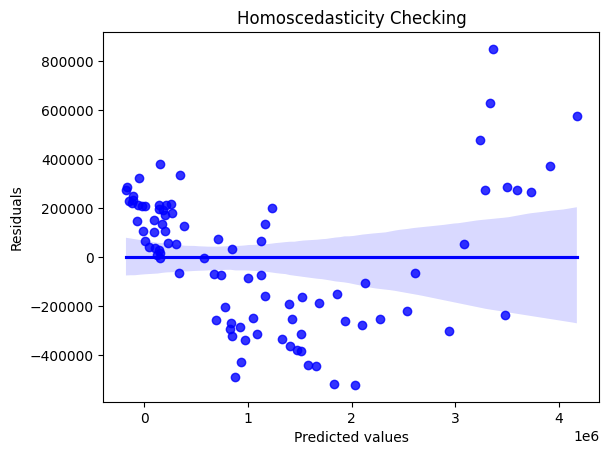

In [13]:
# 3A. Homoskedasticity
fig=sns.regplot(x=pooledOLS_res.fitted_values, y=pooledOLS_res.resids, color = 'blue')
fig.set(xlabel='Predicted values',ylabel='Residuals',title='Homoscedasticity Checking')
plt.savefig('Plot_1.pdf')

* Heteroscedasticity is Present

## Checking presence of serial correlation

In [14]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson
pooled_OLS_dataset = pd.concat([dataset, pooledOLS_res.resids], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['I'], axis = 1).fillna(0)
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 

In [15]:
#print resullts
durbin_watson_test_results

0.43416243845184355

* As DW statistics value is <2, serial correlation is present

## Random effect model

In [16]:
#RE model
from linearmodels import RandomEffects

In [17]:
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 

In [18]:
#print resullts
re_res

Dep. Variable:,C,R-squared:,0.9113
Estimator:,RandomEffects,R-squared (Between):,0.9570
No. Observations:,90,R-squared (Within):,0.8974
Date:,"Wed, Sep 06 2023",R-squared (Overall):,0.9331
Time:,20:23:03,Log-likelihood,-1248.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,294.50
Entities:,6,P-value,0.0000
Avg Obs:,15.000,Distribution:,"F(3,86)"
Min Obs:,15.000,,
Max Obs:,15.000,F-statistic (robust):,294.50


## Fixed effect model

### Fixed effect model with dummy variable teardown

In [21]:
from linearmodels import PooledOLS
import statsmodels.api as sm

In [19]:
# Perform PooledOLS
exog_1= sm.add_constant(dataset[['Q','PF','LF','I']])
endog = dataset['C']
mod_fe = PooledOLS(endog, exog_1)
mod_fe_res = mod_fe.fit(cov_type='clustered', cluster_entity=True)

In [25]:
#print resullts
mod_fe_res

Dep. Variable:,C,R-squared:,0.9716
Estimator:,PooledOLS,R-squared (Between):,1.0000
No. Observations:,90,R-squared (Within):,0.9294
Date:,"Wed, Sep 06 2023",R-squared (Overall):,0.9716
Time:,20:23:38,Log-likelihood,-1226.1
Cov. Estimator:,Clustered,,
,,F-statistic:,346.92
Entities:,6,P-value,0.0000
Avg Obs:,15.000,Distribution:,"F(8,81)"
Min Obs:,15.000,,
Max Obs:,15.000,F-statistic (robust):,8.414e+16


### Fixed effect model without dummy variable teardown

In [22]:
from linearmodels.panel import PanelOLS

In [23]:
#FE model showing constribution of each dummy variable 
model_fe = PanelOLS(endog, exog,entity_effects=True) 
fe_res = model_fe.fit() 

In [24]:
#print resullts
fe_res

Dep. Variable:,C,R-squared:,0.9294
Estimator:,PanelOLS,R-squared (Between):,0.4449
No. Observations:,90,R-squared (Within):,0.9294
Date:,"Wed, Sep 06 2023",R-squared (Overall):,0.6394
Time:,20:24:16,Log-likelihood,-1226.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,355.25
Entities:,6,P-value,0.0000
Avg Obs:,15.000,Distribution:,"F(3,81)"
Min Obs:,15.000,,
Max Obs:,15.000,F-statistic (robust):,355.25


## Hausman test for selection of FEM vs REM

In [26]:
import numpy.linalg as la
from scipy import stats
import numpy as np

In [27]:
#Perform Hausman-Test
def hausman(fe, re):
    b= fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

In [28]:
hausman_results = hausman(fe_res, re_res) 

In [29]:
#print resullts
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom:' + str(hausman_results[1]))
print('p-Value:' + str(hausman_results[2]))

chi-Squared: 60.869537603133686
degrees of freedom:4
p-Value:1.904399777227233e-12


Thus, fixed effect model is preferred